In [69]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt


In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
def transfer_function(z):
    numerator = -z**2 + 1.9 * z + 0.95
    denominator = z**3 - 0.18 * z**2 + 0.08 * z - 0.08
    return numerator / denominator

In [ ]:
def generate_delayed_data(data, delays):
    delayed_data = []
    for delay in delays:
        padded_data = torch.cat([torch.zeros(delay), data[:-delay]])
        delayed_data.append(padded_data)
    return torch.stack(delayed_data, dim=1)


In [73]:
class StaticEstimator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(StaticEstimator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        return self.fc2(x)


In [ ]:
# Example white noise input signal
input_signal = torch.randn(100)
input_delays = [1, 2]
output_delays = [1, 2]

# Generate delayed inputs and outputs
input_data_d = generate_delayed_data(input_signal, input_delays)
input_data = torch.cat([input_signal.reshape(-1,1), input_data_d], dim=1)
output_data = generate_delayed_data(transfer_function(input_signal), output_delays)


In [ ]:
# Initialize the model, loss, and optimizer
model = StaticEstimator(input_dim=input_data.shape[1] + output_data.shape[1], hidden_dim=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare the data
X = torch.cat([input_data, output_data], dim=1)
y = transfer_function(input_signal).view(-1, 1)

# Training loop
num_epochs = 100000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

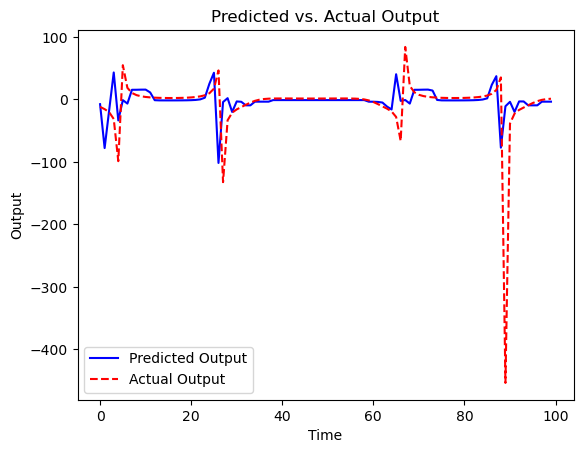

In [ ]:
# Test the model with a new input signal (e.g., a sine wave)
test_input = torch.sin(torch.linspace(0, 10, 100))
test_input_data = generate_delayed_data(test_input, input_delays)
test_input_data = torch.cat([test_input.reshape(-1,1), test_input_data], dim=1)
test_output_data = generate_delayed_data(transfer_function(test_input), output_delays)

# Combine delayed test input and output for prediction
X_test = torch.cat([test_input_data, test_output_data], dim=1).to(device)
predicted_output = model(X_test)

# Plot predicted output and actual output
plt.plot(predicted_output.detach().numpy(), label="Predicted Output", color="blue")
plt.plot(transfer_function(test_input).numpy(), label="Actual Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()